In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage


import seaborn as sns
sns.set_theme(style="darkgrid", palette="pastel")
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
#checando dataframe
data = pd.read_csv('c:/csv/tamanho_pinguins.csv')
data.head()

,especie,ilha,comp_bico_mm,larg_bico_mm,comp_asa_mm,peso_gr,sexo
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [3]:
# nlinhas com valores faltantes
data = data.dropna()

# excluir outliers
data = data[data.larg_bico_mm < 50]

In [4]:
#pegando colunas numericas e coluna com informações da especie
X, y = data.iloc[:, 2:-1], data.iloc[:, 0]

#escalando de 0 a 1
scaler = MinMaxScaler()
X_ = scaler.fit_transform(X)
X_

array([[0.25454545, 0.66666667, 0.15254237, 0.29166667],
       [0.26909091, 0.51190476, 0.23728814, 0.30555556],
       [0.29818182, 0.58333333, 0.38983051, 0.15277778],
       ...,
       [0.66545455, 0.30952381, 0.84745763, 0.84722222],
       [0.47636364, 0.20238095, 0.6779661 , 0.69444444],
       [0.64727273, 0.35714286, 0.69491525, 0.75      ]])

In [5]:
#pegando colunas 0 e 2, Comprimento bico e asa
x = X_[:, [0,2]]

In [6]:
#achar 2 clusters
kmeans = KMeans(n_clusters=2, random_state=3, n_init="auto").fit(x)
labels = kmeans.labels_ #predição de grupos, quais grupos cada objeto foi atribuido

In [7]:
#criando dataframe com comprimento do bico e asa, e inserindo os clusters
df_kmeans = pd.DataFrame(x, columns = ['comp_bico_mm', 'comp_asa_mm'])
df_kmeans['cluster'] = labels

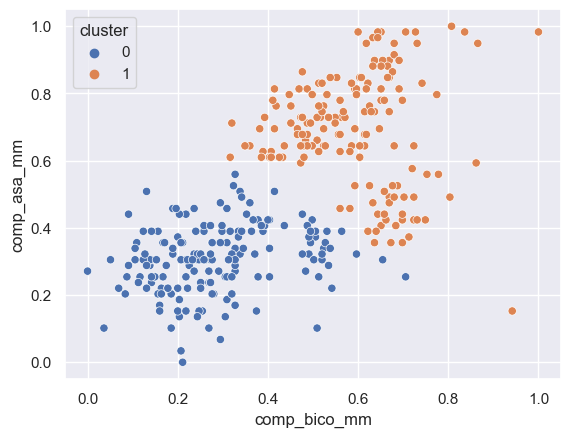

In [8]:
#visualizando grupos
sns.scatterplot(data=df_kmeans, 
                x="comp_bico_mm", 
                y="comp_asa_mm", 
                hue="cluster", 
                palette="deep");

In [9]:
#checando com dbscan
#raio = 1, quantidade minima de pontos pra ser considerada um core = 7
db = DBSCAN(eps=.1, min_samples=7).fit(x)
labels = db.labels_

#criando um df
df_db = pd.DataFrame(x, columns = ['comp_bico_mm', 'comp_asa_mm'])
df_db['cluster'] = labels

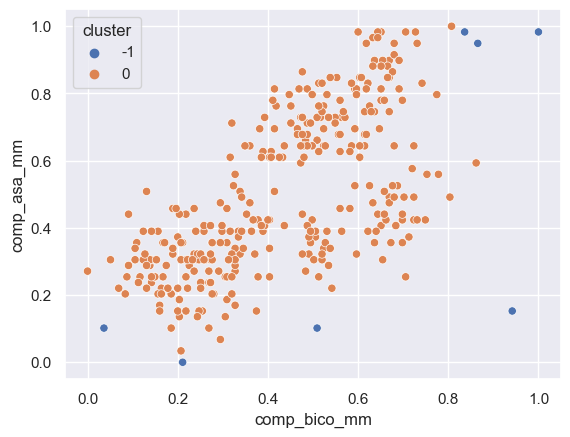

In [10]:
#resultado só um cluster
sns.scatterplot(data=df_db, 
                x="comp_bico_mm", 
                y="comp_asa_mm", 
                hue="cluster", 
                palette="deep");

In [11]:
#checando quantos grupos
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

1

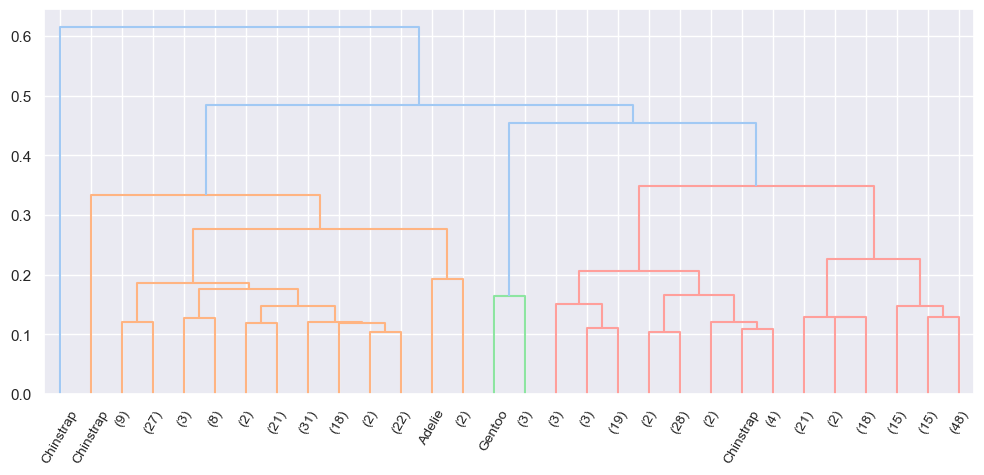

In [12]:
#usando a base de dados pra fazer um agrupamento hierarquico
#passando a base com 2 colunas
Z = linkage(x, method='centroid')

plt.figure(figsize=(12,5))
dendrogram(Z,  truncate_mode='lastp', labels=list(data.especie),#função dendograma
           orientation='top',
           leaf_font_size=10,leaf_rotation=60,);

#cada cor = um grupo

In [13]:
from yellowbrick.cluster import SilhouetteVisualizer
sns.set_theme(style="darkgrid", palette="pastel")

from sklearn import metrics

In [14]:
#cluster de k=2 até k=6
for i in range(2,6):
    kmeans_model = KMeans(n_clusters=i, random_state=42).fit(X_)
    labels = kmeans_model.labels_
    print(f"k={i} - silhueta={metrics.silhouette_score(X_, labels, metric='euclidean'):.3f}")
    
#com esse resultado é considerado q com 2 clusters é o melhor caminho

k=2 - silhueta=0.549
k=3 - silhueta=0.434
k=4 - silhueta=0.379
k=5 - silhueta=0.367


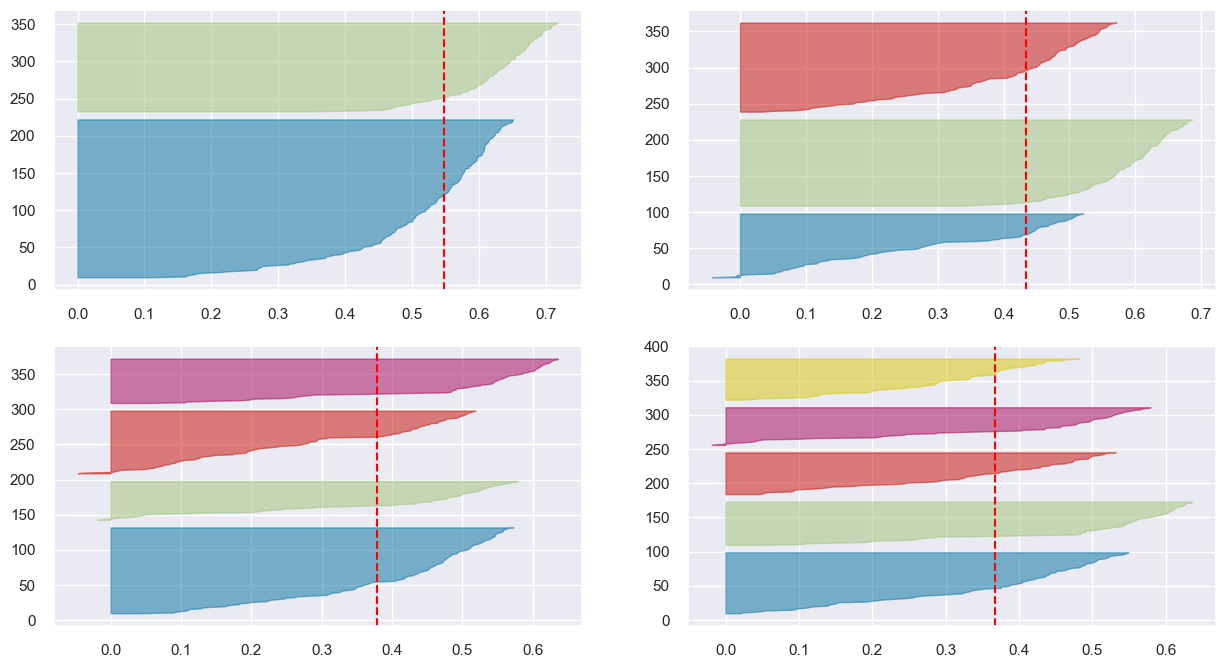

In [15]:
#modelo de k-means
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:#cluster variando pelo i
    '''
    Criar um modelo para cada um dos valores de k
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Criar um modelo de para visualizar a silhueta
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_) 
    
#com 2 grupos novamente o resultado parece ser melhor    

In [16]:
list_eps = [.02, .05, .07, .1]#variando o raio
for i in list_eps:
    db = DBSCAN(eps=i, min_samples=3).fit(X_)#criando um objeto dbscan pra cada um dos raios
    labels = db.labels_
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) #quantos clusters foram criando
    n_noise_ = list(labels).count(-1)#removendo ruindos
    
    if n_clusters_ > 1:#se tiver mais de um cluster roda a silhueta
        silhueta = metrics.silhouette_score(X_, labels, metric='euclidean')
        print(f"eps={i}, clusters={n_clusters_}, silhueta={silhueta:.3f}, ruído={n_noise_}")
    else:
        print(f"1 cluster, ruído={list(labels).count(-1)}")

1 cluster, ruído=333
eps=0.05, clusters=5, silhueta=-0.454, ruído=317
eps=0.07, clusters=23, silhueta=-0.320, ruído=213
eps=0.1, clusters=3, silhueta=0.289, ruído=76


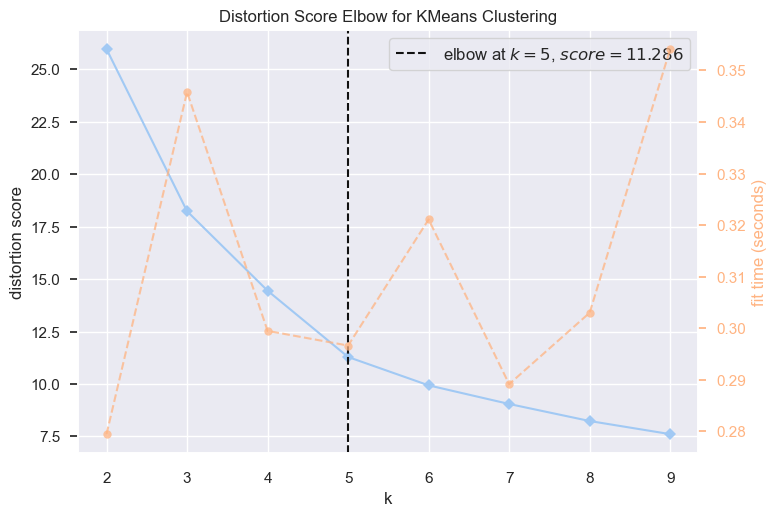

In [17]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()#kemeans do sicktlearn

#k deve variar de 2 a 10
#instanciando o kelbow
visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion', timings= True)
visualizer.fit(X_) 
visualizer.show(); 

#definindo que o melhor valor de k = 5

In [18]:
x = X_[:, [0,2]]

kmeans = KMeans(n_clusters=5, random_state=3, n_init="auto").fit(X_)
labels = kmeans.labels_#guardando valores do kmeans

df_kmeans = pd.DataFrame(x, columns = ['comp_bico_mm', 'comp_asa_mm'])
df_kmeans['cluster'] = labels

In [19]:
#checando base criada anteriormente
df_kmeans.head()

,comp_bico_mm,comp_asa_mm,cluster
0,0.254545,0.152542,2
1,0.269091,0.237288,2
2,0.298182,0.389831,2
3,0.167273,0.355932,3
4,0.261818,0.305085,3


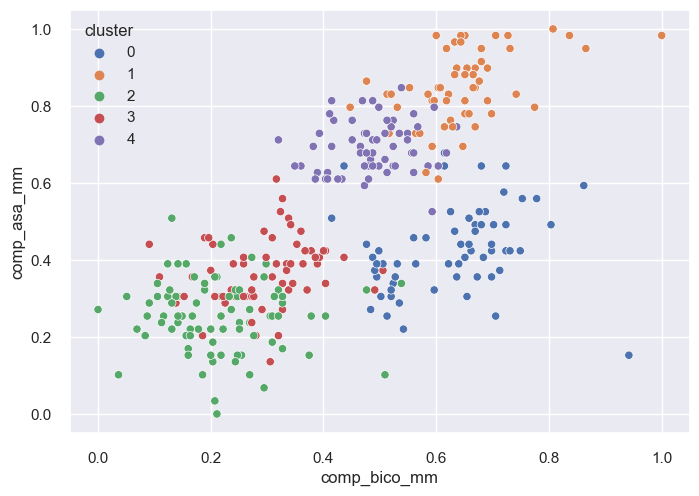

In [20]:
#checando clusters
sns.scatterplot(data=df_kmeans, 
                x="comp_bico_mm", 
                y="comp_asa_mm", 
                hue="cluster", 
                palette="deep");

In [21]:
from sklearn.decomposition import PCA

# visualização 2D
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X_)

print(pca.explained_variance_ratio_)

[0.69609847 0.19189658]


In [22]:
df_pca = pd.DataFrame(pca_features, columns = ['component1', 'component2'])
df_pca['cluster'] = labels

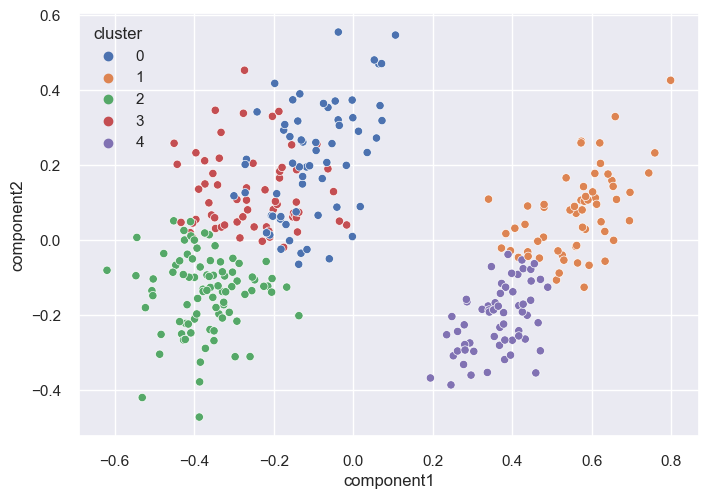

In [23]:
sns.scatterplot(data=df_pca, 
                x="component1", 
                y="component2", 
                hue="cluster", 
                palette="deep");

In [24]:
#criterios externos
#encontrar o algoritmo de agrupamento que melhor se adequa a base
from sklearn import metrics

In [25]:
#valores de k=2 a 11
for i in range(2,11):
    kmeans_model = KMeans(n_clusters=i, random_state=42).fit(X_)#numero de clusters = i
    labels = kmeans_model.labels_#guardando os labels
    print(f"k={i} - rand index={metrics.rand_score(labels, y):.3f}")#imprimindo o k e o valor da metrica
#O melhor valor de k vai ser o que entregar o maior index, nesse caso foi o k=3


k=2 - rand index=0.822
k=3 - rand index=0.882
k=4 - rand index=0.815
k=5 - rand index=0.817
k=6 - rand index=0.804
k=7 - rand index=0.784
k=8 - rand index=0.759
k=9 - rand index=0.748
k=10 - rand index=0.747


In [26]:
list_eps = [.02, .05, .07, .1, 1.2]#valores do raio
for i in list_eps:
    db = DBSCAN(eps=i, min_samples=3).fit(X_)
    labels = db.labels_
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    rand_index = metrics.rand_score(labels, y)
    print(f"eps={i}, clusters={n_clusters_}, rand index={rand_index:.3f}, ruído={n_noise_}")
#checando raio, cluster, index e ruidos
# o melhor index foi o 3

eps=0.02, clusters=0, rand index=0.359, ruído=333
eps=0.05, clusters=5, rand index=0.385, ruído=317
eps=0.07, clusters=23, rand index=0.548, ruído=213
eps=0.1, clusters=3, rand index=0.839, ruído=76
eps=1.2, clusters=1, rand index=0.359, ruído=0


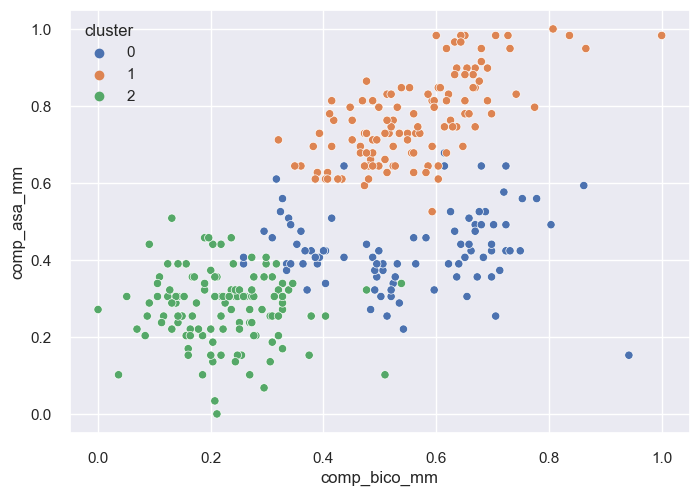

In [27]:
#testando com k-means
#definindo um df com 2 colunas
x = X_[:, [0,2]]
kmeans = KMeans(n_clusters=3, random_state=3, n_init="auto").fit(X_)
labels = kmeans.labels_

df_kmeans = pd.DataFrame(x, columns = ['comp_bico_mm', 'comp_asa_mm'])
df_kmeans['cluster'] = labels

sns.scatterplot(data=df_kmeans, 
                x="comp_bico_mm", 
                y="comp_asa_mm", 
                hue="cluster", 
                palette="deep");

#visualizando os grupos

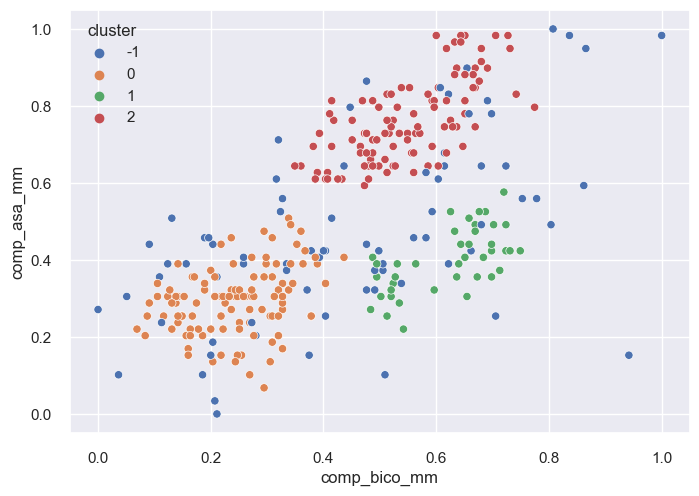

In [28]:
#testando com dbscan
db = DBSCAN(eps=.1, min_samples=3).fit(X_)
labels = db.labels_

df_db = pd.DataFrame(x, columns = ['comp_bico_mm', 'comp_asa_mm'])
df_db['cluster'] = labels

sns.scatterplot(data=df_db, 
                x="comp_bico_mm", 
                y="comp_asa_mm", 
                hue="cluster", 
                palette="deep");

In [29]:
#visualizando com 2 dimensões com PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X_)

print(pca.explained_variance_ratio_)

[0.69609847 0.19189658]


In [30]:
df_pca = pd.DataFrame(pca_features, columns = ['component1', 'component2'])
df_pca['cluster'] = labels

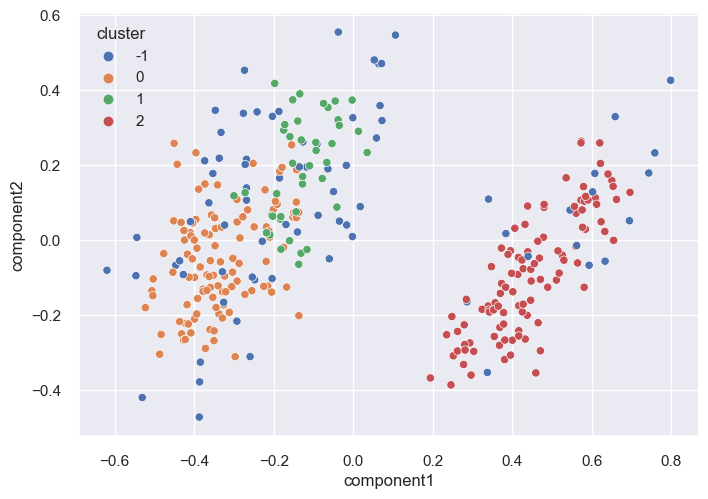

In [31]:
sns.scatterplot(data=df_pca, 
                x="component1", 
                y="component2", 
                hue="cluster", 
                palette="deep");
#observando os grupos com visualização 2D é chegada a conclusão que há 2 grupos bem similares e um bem diferente